In [46]:
# Import neccessary tools
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
# import tensorflow.compat.v1 as tf
from tensorflow.python.client import device_lib

print("TF version:", tf.__version__)


TF version: 2.5.0


In [22]:
### Import dog breeds
unique_breeds = np.array([i.strip("\n") for i in open("dog_breeds.txt").readlines()])

In [23]:
# Define image size,
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    '''
    Takes an image file path and turns the image into a tensor
    '''
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpg image into numeric tensor with three colour channels RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0 to 255 to 0 to 1 values
    # Normlising the values makes tf perform the functions easier
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Resize the image to our desired value (224, 224)
    image = tf.image.resize(image, [img_size, img_size])

    return image


In [24]:
def get_image_label(image_path, label):

    '''
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image,label)
    '''

    image = process_image(image_path)

    return image, label

In [59]:
# Turn probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    '''
    Turns an array of predictiion probabilites into a label.
    '''

    return unique_breeds[np.argmax(prediction_probabilities)], np.argmax(prediction_probabilities)*100


Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [68]:
def plot_pred(prediction_probabilities, labels , images, n=1):
    '''
    View the prediction, ground truth and image for sample n
    '''
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

#     pred_prob, true_label, image = prediction_probabilities[n], unique_breeds[labels[n].argmax()], images[n]

    pred_label = get_pred_label(pred_prob)

    # PLot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Change the colour of the title depedning on whether the prediction is right or wrong
    if(pred_label == true_label):
        color = "green"
    else:
        color = "red"
    
    
    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label.title(),
                                             np.max(pred_prob)*100, true_label.capitalize())
                                      , color=color)

In [33]:
# Define the batch size thats a good start
BATCH_SIZE = 32

# Create a function to turn data into batches. Each for the training, validation, and test
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    '''
    Creates bacthes of data out of the image (X) and label (y) pairs.
    Shuffles the data  if its training data but doesn't shuffle if its validation data.
    Also accepts test data as input (no labels)
    '''
    X = tf.constant(X)
    y = tf.constant(y) if(not y == None) else None
    # If data is a test dataset, we probably don't have label
    if(test_data):
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((X)) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE) # the slice data set is what is going to the function with map so the data becomes the parameter

        return data_batch

    # If the data is a validation (valid_data) dataset, we don't need to shuffle it??
    # Why?? because the training data maybe in some sequence but its not important for the validation data
    elif(valid_data):
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((X, # filepaths
                                                   y)) # labels
        data = data.map(get_image_label)

        data_batch = data.batch(BATCH_SIZE)

        return data_batch

    else:
        print("Creating training data bacthes")
        # X = tf.random.shuffle(X, seed=42) 
        # y = tf.random.shuffle(y, seed=42)

        data = tf.data.Dataset.from_tensor_slices((X, 
                                                   y))
        # Shuffling pathnames and labels before mapping is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image) 
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)

        return data_batch

In [30]:
# Create a function to load a trained model
def load_model(model_path):
    ''''
    Loads a saved model from a specified path
    '''
    print(f"Loading a saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer": hub.KerasLayer})
    
    return model

In [32]:
# Load a trained model
model = load_model("model{0}".format(os.sep))

Loading a saved model from: model\


In [37]:
def test_dog_predictor(predictions, index=0):
    print(predictions[index])
    print(f"Max value (probability of prediction): {np.max(predictions[index])}")
    print(f"Sum: {np.sum(predictions[index])}")
    print(f"Max index: {np.argmax(predictions[index])}")
    print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

### Making predictions on custom images, we'll:
* Get the file paths
* Turn the filepaths into data batches using `create_data_batches`. And since our custom images won't have labels, we set the `test_data` parameter to `True`
* Pass the custom image data batch to our models predict() method
* Convert the prediction probabilities to prediction labels
* Compare the predicted labels to the custom images

In [34]:
# The the custom image filepaths
custom_path="custom"
custom_image_paths = [f"{custom_path}{os.sep}{fname}" for fname in os.listdir(custom_path)]

# Obtain the custom data batches for predictions
custom_data = create_data_batches(custom_image_paths, test_data=True)

Creating test data batches...


In [35]:
# Predict the outcomes
custom_predictions = model.predict(custom_data)

In [56]:
custom_pred_label = [get_pred_label(custom_predictions[i]) for i in range(len(custom_predictions))]

In [57]:
custom_pred_label

['golden_retriever', 'newfoundland', 'border_collie']

In [43]:
# Get custom images (our unbatchify()) function won't work since there arent labels... maybe we could fix this later)
custom_images = []
# loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
    custom_images.append(image)

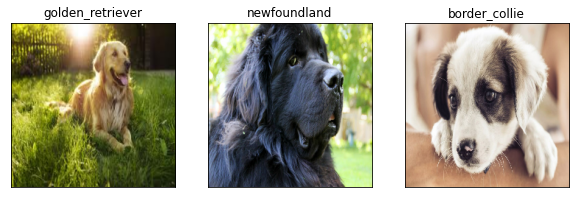

In [47]:
# Check custom image predictions

plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
    plt.subplot(1, 3, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(custom_pred_label[i])
    plt.imshow(image)